# Estimation of bootstrap covariances for galaxy-forest cross-correlation
We randomly resample (with replacement) both the galaxy positios and Ly-a forest pixels.

### Read in galaxy positions and forest pixels.

In [12]:
import numpy as np
import copy
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord


# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)
    
# Read forest pixels    
LyaPix = xcorr.lyapix("pixel_radecz.bin",cosmo=cosmo)

print("Read in %i Ly-a forest pixels" % LyaPix.npix)
npix = LyaPix.npix

# Done with forest pixels. Now read galaxy positions
galfil = '/Users/kheegan/lya/3d_recon/map2017/crosscorr/cat_galxcorr_cl2017.dat'
gal = ascii.read(galfil)
#print(gal.columns)

gal_3d = gal[gal['source'] == '3DHST']
gal_zD = gal[gal['source'] == 'zDEEP']
gal_mosdef = gal[gal['source'] == 'MOSDEF']
gal_vuds   = gal[gal['source']=='VUDS']
gal_clamato=gal[gal['source']=='CLAMATO']

print('Read in %i 3D-HST galaxies, %i zCOSMOS-Deep galaxies, %i MOSDEF galaxies,' 
      '%i VUDS galaxies, %i CLAMATO galaxies' % 
      (len(gal_3d), len(gal_zD), len(gal_mosdef), len(gal_vuds), len(gal_clamato)) )

# Convert to 3D Sky positions
Coord_3d     = SkyCoord(ra=gal_3d['ra'] * u.degree, dec=gal_3d['dec'] * u.degree,
                  distance=cosmo.comoving_distance(gal_3d['zspec']))
Coord_zD     = SkyCoord(ra=gal_zD['ra'] * u.degree, dec=gal_zD['dec'] * u.degree,
                   distance=cosmo.comoving_distance(gal_zD['zspec']))
Coord_vuds     = SkyCoord(ra=gal_vuds['ra'] * u.degree, dec=gal_vuds['dec'] * u.degree,
                   distance=cosmo.comoving_distance(gal_vuds['zspec']))
Coord_mosdef = SkyCoord(ra=gal_mosdef['ra'] * u.degree, dec=gal_mosdef['dec'] * u.degree,
                   distance=cosmo.comoving_distance(gal_mosdef['zspec']))
Coord_clamato = SkyCoord(ra=gal_clamato['ra'] * u.degree, dec=gal_clamato['dec'] * u.degree,
                   distance=cosmo.comoving_distance(gal_clamato['zspec']))

# Read in bin edges
PiBin_fil = 'bins16_pi_0-40hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])
PiBound = (min(PiEdges), max(PiEdges) )

Read in 89974 Ly-a forest pixels
Read in 234 3D-HST galaxies, 362 zCOSMOS-Deep galaxies, 121 MOSDEF galaxies,303 VUDS galaxies, 118 CLAMATO galaxies


### Bootstrap MOSDEF Sample
We perform the bootstrap and plot a few resampled cross-correlations as a sanity check.

In [2]:
nsamp=200
np.random.seed(seed=123456)

GalCoords = Coord_mosdef
ngal = len(GalCoords)

# Initialize output array to store all the bootstrap samples
XCorrSamples_mosdef = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

# This is the loop over the desired resamples
for ii in range(0,nsamp):
    if (ii % 5) == 0:
        print("Iteration #", ii)
    # Make a copy of the pixels and resample
    LyaPixTmp = copy.deepcopy(LyaPix)
    LyaPixTmp = LyaPixTmp.resample()
    # Resample galaxy positions
    GalCoordTmp = GalCoords[np.random.choice(ngal,ngal,replace=True)]
    XCorrTmp, _ = xcorr.xcorr_gal_lya(GalCoordTmp, LyaPixTmp,SigEdges, PiEdges,
                                      cosmo=cosmo,verbose=0)
    XCorrSamples_mosdef[:,:,ii] = XCorrTmp

Iteration # 0
Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50
Iteration # 55
Iteration # 60
Iteration # 65
Iteration # 70
Iteration # 75
Iteration # 80
Iteration # 85
Iteration # 90
Iteration # 95
Iteration # 100
Iteration # 105
Iteration # 110
Iteration # 115
Iteration # 120
Iteration # 125
Iteration # 130
Iteration # 135
Iteration # 140
Iteration # 145
Iteration # 150
Iteration # 155
Iteration # 160
Iteration # 165
Iteration # 170
Iteration # 175
Iteration # 180
Iteration # 185
Iteration # 190
Iteration # 195


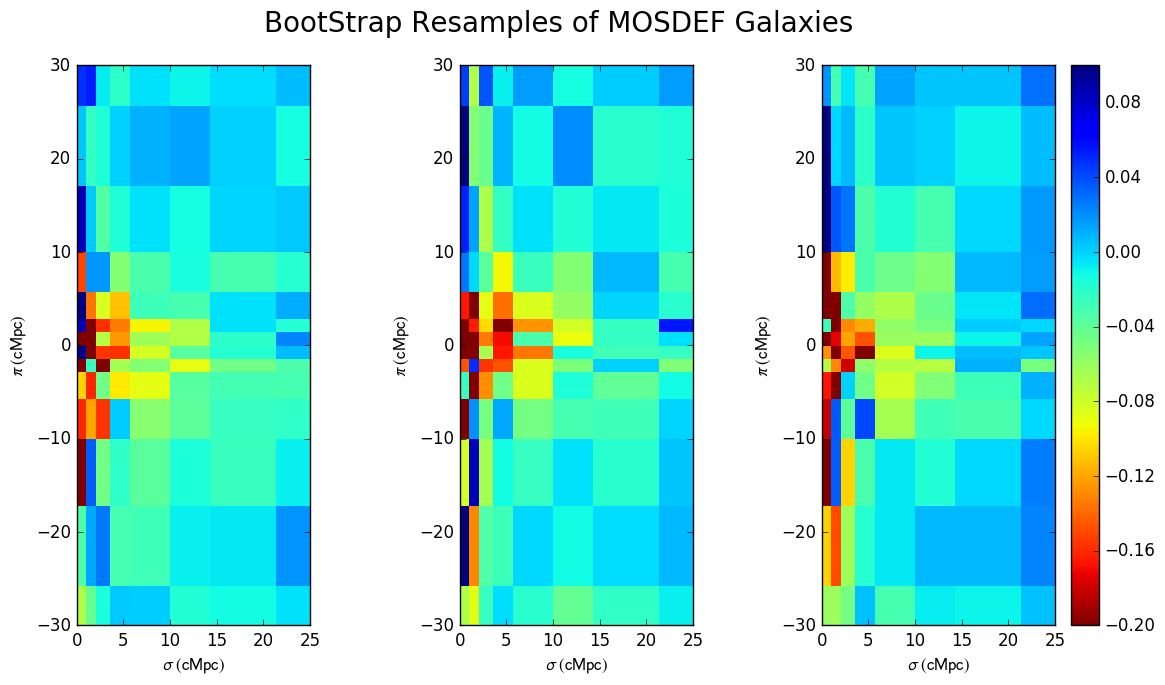

In [3]:
XCorr1 = np.transpose(XCorrSamples_mosdef[:,:,0])
XCorr2 = np.transpose(XCorrSamples_mosdef[:,:,1])
XCorr3 = np.transpose(XCorrSamples_mosdef[:,:,2])

X, Y = np.meshgrid(SigEdges, PiEdges)

SigMax = 25.
PiMin = -30.
PiMax = 30.

fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(14,7))

fig.suptitle("BootStrap Resamples of MOSDEF Galaxies", fontsize=20)

ax1.pcolormesh(X, Y, XCorr1,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

ax2.pcolormesh(X, Y, XCorr2,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

pcm=ax3.pcolormesh(X, Y, XCorr3,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax3.set_aspect('equal')
ax3.set_xlim(np.min(X), SigMax)
ax3.set_ylim(PiMin, PiMax)
ax3.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax3.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')

fig.colorbar(pcm, ax=ax3)

#fig.subplots_adjust(wspace=-0.1)

plt.show()

Compute the covariance matrix. We compare the diagonal terms with the variance as a sanity check. 

We have recovered original shape:  True


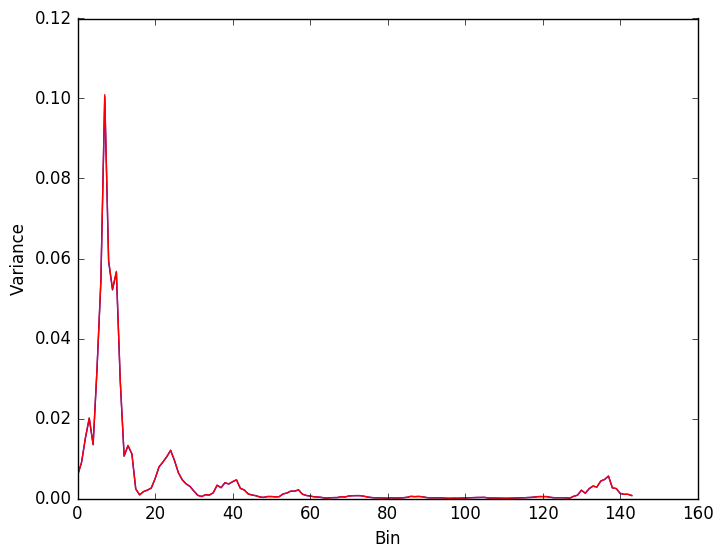

In [4]:
# First, reshape the bootstrap samples so that it has dimensions (nbin, nsamp)
XBootReshaped = XCorrSamples_mosdef.reshape(-1, XCorrSamples_mosdef.shape[-1])

# Quick test that we can recover the original shape
XBootBack = XBootReshaped.reshape(XCorrSamples_mosdef.shape)
print("We have recovered original shape: ", 
      np.all(np.isclose(XBootBack, XCorrSamples_mosdef,rtol=1.e-3)))

Covar_mosdef = np.cov(XBootReshaped)
CovDiag_mosdef = Covar_mosdef.diagonal()

# This are the diagonal covariances
VarArr= np.var(XCorrSamples_mosdef, axis=2)

NVec = np.arange(VarArr.size)


fig, ax = plt.subplots()
ax.plot(NVec, VarArr.reshape(VarArr.size))
ax.plot(NVec, CovDiag_mosdef, color='r')
ax.set_ylabel('Variance')
ax.set_xlabel('Bin')

plt.show()


### Bootstrap VUDS Sample

In [5]:
nsamp=200
np.random.seed(seed=123456)

GalCoords = Coord_vuds
ngal = len(GalCoords)

# Initialize output array to store all the bootstrap samples
XCorrSamples_vuds = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

# This is the loop over the desired resamples
for ii in range(0,nsamp):
    if (ii % 5) == 0:
        print("Iteration #", ii)
    # Make a copy of the pixels and resample
    LyaPixTmp = copy.deepcopy(LyaPix)
    LyaPixTmp = LyaPixTmp.resample()
    # Resample galaxy positions
    GalCoordTmp = GalCoords[np.random.choice(ngal,ngal,replace=True)]
    XCorrTmp, _ = xcorr.xcorr_gal_lya(GalCoordTmp, LyaPixTmp,SigEdges, PiEdges,
                                      cosmo=cosmo,verbose=0)
    XCorrSamples_vuds[:,:,ii] = XCorrTmp

Iteration # 0
Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50
Iteration # 55
Iteration # 60
Iteration # 65
Iteration # 70
Iteration # 75
Iteration # 80
Iteration # 85
Iteration # 90
Iteration # 95
Iteration # 100
Iteration # 105
Iteration # 110
Iteration # 115
Iteration # 120
Iteration # 125
Iteration # 130
Iteration # 135
Iteration # 140
Iteration # 145
Iteration # 150
Iteration # 155
Iteration # 160
Iteration # 165
Iteration # 170
Iteration # 175
Iteration # 180
Iteration # 185
Iteration # 190
Iteration # 195


In [6]:
# First, reshape the bootstrap samples so that it has dimensions (nbin, nsamp)
XBootReshaped = XCorrSamples_vuds.reshape(-1, XCorrSamples_vuds.shape[-1])
Covar_vuds = np.cov(XBootReshaped)

### Bootstrap zCOSMOS-Deep Sample

In [7]:
nsamp=200
np.random.seed(seed=123456)

GalCoords = Coord_zD
ngal = len(GalCoords)

# Initialize output array to store all the bootstrap samples
XCorrSamples_zD = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

# This is the loop over the desired resamples
for ii in range(0,nsamp):
    if (ii % 5) == 0:
        print("Iteration #", ii)
    # Make a copy of the pixels and resample
    LyaPixTmp = copy.deepcopy(LyaPix)
    LyaPixTmp = LyaPixTmp.resample()
    # Resample galaxy positions
    GalCoordTmp = GalCoords[np.random.choice(ngal,ngal,replace=True)]
    XCorrTmp, _ = xcorr.xcorr_gal_lya(GalCoordTmp, LyaPixTmp,SigEdges, PiEdges,
                                      cosmo=cosmo,verbose=0)
    XCorrSamples_zD[:,:,ii] = XCorrTmp

Iteration # 0
Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50
Iteration # 55
Iteration # 60
Iteration # 65
Iteration # 70
Iteration # 75
Iteration # 80
Iteration # 85
Iteration # 90
Iteration # 95
Iteration # 100
Iteration # 105
Iteration # 110
Iteration # 115
Iteration # 120
Iteration # 125
Iteration # 130
Iteration # 135
Iteration # 140
Iteration # 145
Iteration # 150
Iteration # 155
Iteration # 160
Iteration # 165
Iteration # 170
Iteration # 175
Iteration # 180
Iteration # 185
Iteration # 190
Iteration # 195


In [8]:
# First, reshape the bootstrap samples so that it has dimensions (nbin, nsamp)
XBootReshaped = XCorrSamples_zD.reshape(-1, XCorrSamples_zD.shape[-1])
Covar_zD = np.cov(XBootReshaped)


### Bootstrap CLAMATO sample

In [13]:
nsamp=200
np.random.seed(seed=1234567)

GalCoords = Coord_clamato
ngal = len(GalCoords)

# Initialize output array to store all the bootstrap samples
XCorrSamples_clamato = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

# This is the loop over the desired resamples
for ii in range(0,nsamp):
    if (ii % 5) == 0:
        print("Iteration #", ii)
    # Make a copy of the pixels and resample
    LyaPixTmp = copy.deepcopy(LyaPix)
    LyaPixTmp = LyaPixTmp.resample()
    # Resample galaxy positions
    GalCoordTmp = GalCoords[np.random.choice(ngal,ngal,replace=True)]
    XCorrTmp, _ = xcorr.xcorr_gal_lya(GalCoordTmp, LyaPixTmp,SigEdges, PiEdges,
                                      cosmo=cosmo,verbose=0)
    XCorrSamples_clamato[:,:,ii] = XCorrTmp
    
# First, reshape the bootstrap samples so that it has dimensions (nbin, nsamp)
XBootReshaped = XCorrSamples_clamato.reshape(-1, XCorrSamples_clamato.shape[-1])
Covar_clamato = np.cov(XBootReshaped)

Iteration # 0
Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50
Iteration # 55
Iteration # 60
Iteration # 65
Iteration # 70
Iteration # 75
Iteration # 80
Iteration # 85
Iteration # 90
Iteration # 95
Iteration # 100
Iteration # 105
Iteration # 110
Iteration # 115
Iteration # 120
Iteration # 125
Iteration # 130
Iteration # 135
Iteration # 140
Iteration # 145
Iteration # 150
Iteration # 155
Iteration # 160
Iteration # 165
Iteration # 170
Iteration # 175
Iteration # 180
Iteration # 185
Iteration # 190
Iteration # 195


### Bootstrap 3D-HST Sample

In [9]:
nsamp=200
np.random.seed(seed=123456)

GalCoords = Coord_3d
ngal = len(GalCoords)

# Initialize output array to store all the bootstrap samples
XCorrSamples_3d = np.empty([len(SigEdges)-1, len(PiEdges)-1, nsamp])

# This is the loop over the desired resamples
for ii in range(0,nsamp):
    if (ii % 5) == 0:
        print("Iteration #", ii)
    # Make a copy of the pixels and resample
    LyaPixTmp = copy.deepcopy(LyaPix)
    LyaPixTmp = LyaPixTmp.resample()
    # Resample galaxy positions
    GalCoordTmp = GalCoords[np.random.choice(ngal,ngal,replace=True)]
    XCorrTmp, _ = xcorr.xcorr_gal_lya(GalCoordTmp, LyaPixTmp,SigEdges, PiEdges,
                                      cosmo=cosmo,verbose=0)
    XCorrSamples_3d[:,:,ii] = XCorrTmp

Iteration # 0
Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50
Iteration # 55
Iteration # 60
Iteration # 65
Iteration # 70
Iteration # 75
Iteration # 80
Iteration # 85
Iteration # 90
Iteration # 95
Iteration # 100
Iteration # 105
Iteration # 110
Iteration # 115
Iteration # 120
Iteration # 125
Iteration # 130
Iteration # 135
Iteration # 140
Iteration # 145
Iteration # 150
Iteration # 155
Iteration # 160
Iteration # 165
Iteration # 170
Iteration # 175
Iteration # 180
Iteration # 185
Iteration # 190
Iteration # 195


In [10]:
# First, reshape the bootstrap samples so that it has dimensions (nbin, nsamp)
XBootReshaped = XCorrSamples_3d.reshape(-1, XCorrSamples_3d.shape[-1])
Covar_3d = np.cov(XBootReshaped)

### Save Covariance Matrices and Bootstrap samples to file

In [11]:
np.save("covar_3dhst_v0.npy", Covar_3d)
np.save("covar_zDeep_v0.npy", Covar_zD)
np.save("covar_mosdef_v0.npy", Covar_mosdef)
np.save("covar_vuds_v0.npy", Covar_vuds)

np.save("bootsamp_3dhst_v0.npy", XCorrSamples_3d)
np.save("bootsamp_zDeep_v0.npy", XCorrSamples_zD)
np.save("bootsamp_mosdef_v0.npy", XCorrSamples_mosdef)
np.save("bootsamp_vuds_v0.npy", XCorrSamples_vuds)

In [14]:
np.save("covar_clamato_v0.npy", Covar_clamato)
np.save("bootsamp_clamato_v0.npy",XCorrSamples_clamato)